In [2]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

#from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.masking import make_mask


dc = datacube.Datacube()
# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Sentinal 2 A&B Geomedian notebook

what does this notebook do? 

In [3]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('plot', fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')


#set up peramiters for sentinal data loading

Ssensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want

Sbands_of_int =['red','blue','green'] #pick the sentinal bands that you want, here i am just using visible light  

Squery = {
        'lat': (-30.755, -30.795),
        'lon': (144.880, 144.940),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-06-01', '2018-01-01')
        }
# use s2b_ard_granule 	 for S2B
#data = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **query)

In [4]:
#Temporal range, wavelengths/band and sensors of interest are defined for LANDSAT

sensors= ['ls8_nbart_albers','ls7_nbart_albers'] #pick the landsat satelites you want

bands_of_int =['red','blue','green', 'nir'] #pick the sentinal bands that you want, here i am just using visible light  


# extent_long = (145.351, 145.448)
# extent_lat = (-30.835, -30.754)

query = {
        'lat': (-30.835, -30.754),
        'lon': (145.351, 145.448),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time':('2016-01-01', '2016-06-01')
        }

# this quiery retreives our data request entered in above cell

#data_land = dc.load(product=Lsensors, measurements=Lbands_of_int, group_by='solar_day',  **Lquery)

#data_land

In [5]:

# #Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

basic_pq_mask = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea': 'land'}

In [10]:
#return masked fc information

sensor_clean = {}
for sensor in sensors: 
    dataset = []
    #product_name = '{}_{}_albers'.format(sensor, 'fc')
    #print('loading {}'.format(sensor))
    
        # load FC and PQ
    data = dc.load(product=sensor, measurements=bands_of_int, group_by='solar_day', **query)
    #pq = dc.load(product=sensor , group_by='solar_day', **query, fuse_func=ga_pq_fuser)
        
    crs = data.crs
    crswkt = data.crs.wkt
    affine = data.affine
        
    # find common observations
    #time = (data.time - pq.time).time  # works!
    #data = data.sel(time=time)
    #pq = pq.sel(time=time)
    
    # mask
    #basic_mask = make_mask(pq, **basic_pq_mask).pixelquality
    #data = data.where(basic_mask)    
    #cloud_free = make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud').pixelquality
   
    #filter with cloud free threshold to remove cloudy scenes
    #mostly_cloud_free = cloud_free.mean(dim=('x', 'y')) >= cloud_free_threshold
    
    # only those observations that were mostly cloud free
    #result = data.where(mostly_cloud_free).dropna(dim='time', how='all')
    
    
    #result.attrs['crs'] = crs
    #result.attrs['affine'] = affine
    #result.coords['product'] = ('time', numpy.repeat(sensor, result.time.size))
    sensor_clean[sensor] = data

print ('complete')

complete


In [14]:
sensor_clean

AttributeError: 'dict' object has no attribute 'isel'

In [12]:
data_group = xr.concat(sensor_clean.values(), 'time')
data_group = data_group.sortby('time')
data_group.attrs['crs'] = crs
data_group.attrs['affin|e'] = affine

In [20]:
one_day = data_group.isel(time=2)
one_day

<xarray.Dataset>
Dimensions:  (x: 404, y: 400)
Coordinates:
  * y        (y) float64 -3.414e+06 -3.414e+06 -3.414e+06 -3.414e+06 ...
  * x        (x) float64 1.262e+06 1.262e+06 1.262e+06 1.262e+06 1.262e+06 ...
    time     datetime64[ns] 2016-01-10T00:15:22
Data variables:
    red      (y, x) int16 1233 1284 1234 1249 1331 1265 1323 1280 1154 1105 ...
    blue     (y, x) int16 351 349 331 348 382 352 355 322 372 354 353 351 ...
    green    (y, x) int16 685 697 643 643 733 668 709 711 603 620 671 685 ...
    nir      (y, x) int16 2172 2192 2079 2184 2334 2210 2264 2234 2193 2154 ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1261700.00|\n| 0.00,-25.00,-3413850.00|\n| 0.00,...

<IPython.core.display.Javascript object>


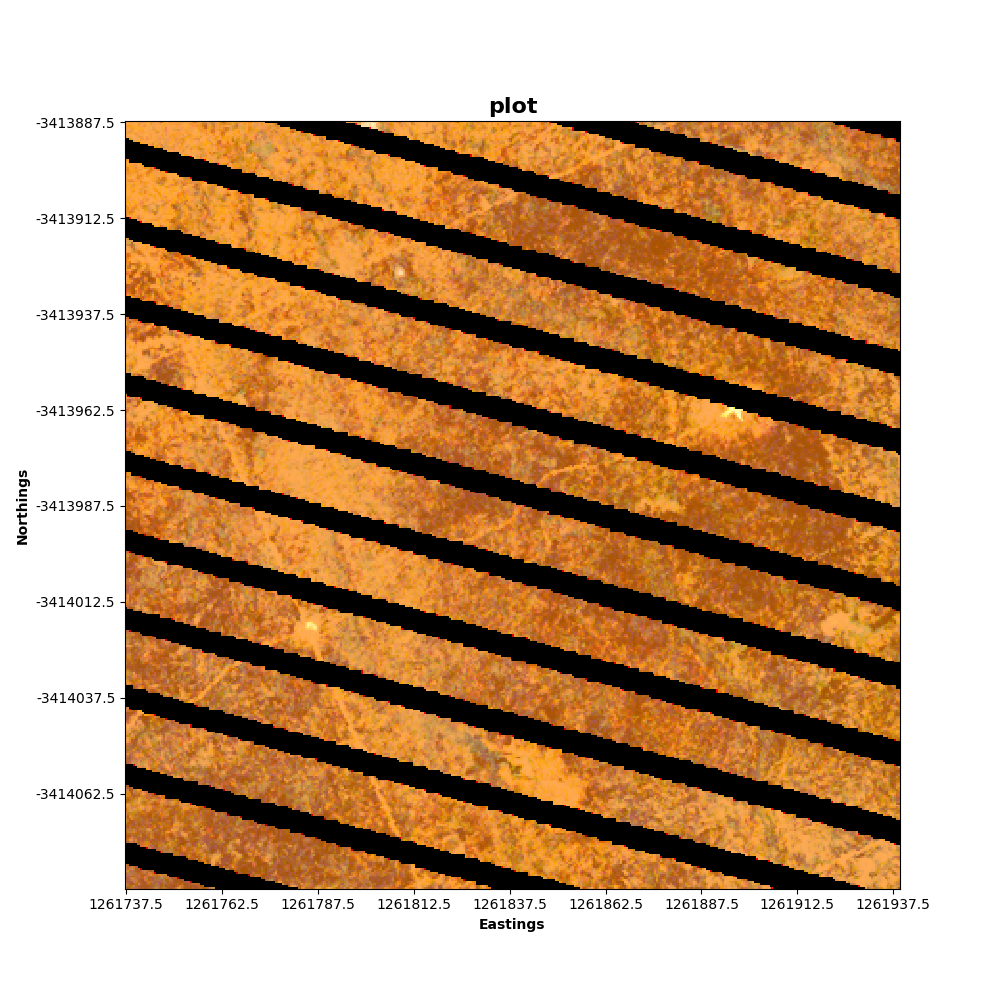

In [21]:
three_band_image_flat(one_day, bands=['red','green','blue'])

In [ ]:
#cast the data to float numbers so geomedian calculation will work
#data_sent_flt = data_sent.astype(float,casting='safe')
data_land_flt = data_group.astype(float,casting='safe')

In [ ]:
#create geomedian for data
#Sentinal_gm=GeoMedian().compute(data_sent_flt)

In [ ]:
#create geomedian for data
lnds_8_gm=GeoMedian().compute(data_land_flt)
    

In [ ]:
#sent_NDVI =  (Sentinal_gm['nir1']-Sentinal_gm['red'])/(Sentinal_gm['nir1']+Sentinal_gm['red'])
land_NDVI =  (lnds_8_gm['nir']-lnds_8_gm['red'])/(lnds_8_gm['nir']+lnds_8_gm['red'])

In [ ]:
#plt.scatter(sent_NDVI.data.ravel(),land_NDVI.data.ravel(), alpha=0.1)

In [ ]:


fig, ax = plt.subplots(figsize=(10,10))
plt.title('median NDVI')
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.80)
cax = ax.imshow(land_NDVI, cmap='Spectral', norm=norm )
cbar = fig.colorbar(cax, fraction=0.038, pad=0.04)

plt.show()

In [ ]:
three_band_image_flat(lnds_8_gm, bands=['red','green','blue'])

In [ ]:
#three_band_image_flat(lnds_8_gm, bands=['red','green','blue'],)